In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

#print('Python', sys.version)

In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset following PyTorch dataloader conventions.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [3]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features,
                 hidden = 64, layers = 2, output_scale = 0.3):
        super().__init__()
        # Build a simple feed-forward network.
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Start logits near zero so spline softmax is well-behaved.
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context = None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [4]:
def conjure_flow(on_unit_box = True, num_flows = 8, hidden_features = 64, num_bins = 8):
    dim = 2
    transforms = []
    if on_unit_box:
        # Use logit pre-transform to map (0,1) to R.
        transforms.append(InverseTransform(Sigmoid()))

    masks = [torch.tensor([1,0], dtype=torch.bool), torch.tensor([0,1], dtype = torch.bool)]
    for i in range(num_flows):
        mask = masks[i % 2]
        def conditioner(in_features, out_features, _hidden = hidden_features):
            return MLP(in_features, out_features, hidden = _hidden, layers = 2)
        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask                          = mask,
                transform_net_create_fn       = conditioner,
                num_bins                      = num_bins,
                tails                         = "linear",
                tail_bound                    = 5.0,
                apply_unconditional_transform = False,
            )
        )
        transforms.append(RandomPermutation(features = dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape = [dim])
    return Flow(transform, base)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
def train_flow(flow, train_loader, lr = 1e-3, epochs = 5,
    device = "cuda" if torch.cuda.is_available() else "cpu"):
    
    flow.to(device)
    # Initialize optimizer.
    opt = torch.optim.Adam(flow.parameters(), lr=lr)

    # Initialize learning rate scheduler.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=2, min_lr=1e-6)

    # Train!
    for epoch in tqdm(range(1, epochs + 1), ncols = 50):
        flow.train()
        running = 0.0
        for xb in train_loader:
            xb = xb.to(device)
            # Negative log-likelihood
            loss = -flow.log_prob(xb).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)

        # Average negative log-likelihood per data point.
        nll = running / len(train_loader.dataset)

        # Update scheduler.
        scheduler.step(loss)

        # Output training analytics.
        print(f"[{epoch:03d}] Loss: {nll:.4f}, lr: {opt.param_groups[0]['lr']:.6f}")

    return flow

In [7]:
# Load in Dalitz dataset
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

In [8]:
# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.8)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
#mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
#valset   = dalitz_dataset(mp_thetap_val)

batch_size = 50000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
#val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

# Initialize hyperparameters
epochs = 50
learning_rate = 0.005
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 25
hidden_features = 128

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

flow = train_flow(flow, train_dataloader, lr = learning_rate, epochs = epochs)

print("Done!")

Training set size:  (2000000, 2) Validation set size:  (8000000, 2)


  0%|                      | 0/50 [00:00<?, ?it/s]/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
  2%|▏           | 1/50 [01:29<1:12:51, 89.22s/it]

[001] Loss: -0.7918, lr: 0.005000


  4%|▍           | 2/50 [03:12<1:18:09, 97.69s/it]

[002] Loss: -1.0870, lr: 0.005000


  6%|▋           | 3/50 [04:42<1:13:36, 93.97s/it]

[003] Loss: -1.1001, lr: 0.005000


  8%|▉           | 4/50 [06:26<1:15:01, 97.85s/it]

[004] Loss: -1.1052, lr: 0.005000


 10%|█          | 5/50 [08:10<1:15:04, 100.09s/it]

[005] Loss: -1.1102, lr: 0.005000


 12%|█▎         | 6/50 [10:02<1:16:19, 104.08s/it]

[006] Loss: -1.1113, lr: 0.005000


 14%|█▌         | 7/50 [11:48<1:15:09, 104.87s/it]

[007] Loss: -1.1131, lr: 0.005000


 16%|█▊         | 8/50 [13:28<1:12:15, 103.22s/it]

[008] Loss: -1.1132, lr: 0.005000


 18%|█▉         | 9/50 [15:11<1:10:38, 103.37s/it]

[009] Loss: -1.1152, lr: 0.005000


 20%|██        | 10/50 [16:50<1:07:57, 101.95s/it]

[010] Loss: -1.1152, lr: 0.004500


 22%|██▍        | 11/50 [18:25<1:04:48, 99.71s/it]

[011] Loss: -1.1168, lr: 0.004500


 24%|██▍       | 12/50 [20:07<1:03:32, 100.33s/it]

[012] Loss: -1.1180, lr: 0.004500


 26%|██▊        | 13/50 [21:38<1:00:11, 97.60s/it]

[013] Loss: -1.1160, lr: 0.004500


 28%|███▋         | 14/50 [23:00<55:46, 92.96s/it]

[014] Loss: -1.1175, lr: 0.004500


 30%|███▉         | 15/50 [24:23<52:21, 89.76s/it]

[015] Loss: -1.1173, lr: 0.004500


 32%|████▏        | 16/50 [25:52<50:49, 89.69s/it]

[016] Loss: -1.1180, lr: 0.004050


 34%|████▍        | 17/50 [27:18<48:39, 88.48s/it]

[017] Loss: -1.1197, lr: 0.004050


 36%|████▋        | 18/50 [28:40<46:11, 86.60s/it]

[018] Loss: -1.1195, lr: 0.004050


 38%|████▉        | 19/50 [30:06<44:36, 86.34s/it]

[019] Loss: -1.1191, lr: 0.003645


 40%|█████▏       | 20/50 [31:39<44:11, 88.38s/it]

[020] Loss: -1.1200, lr: 0.003645


 42%|█████▍       | 21/50 [33:11<43:14, 89.46s/it]

[021] Loss: -1.1203, lr: 0.003645


 44%|█████▋       | 22/50 [34:47<42:37, 91.35s/it]

[022] Loss: -1.1208, lr: 0.003645


 46%|█████▉       | 23/50 [36:21<41:33, 92.36s/it]

[023] Loss: -1.1208, lr: 0.003645


 48%|██████▏      | 24/50 [37:58<40:35, 93.66s/it]

[024] Loss: -1.1196, lr: 0.003645


 50%|██████▌      | 25/50 [39:35<39:23, 94.56s/it]

[025] Loss: -1.1203, lr: 0.003281


 52%|██████▊      | 26/50 [41:20<39:07, 97.80s/it]

[026] Loss: -1.1209, lr: 0.003281


 54%|███████      | 27/50 [43:01<37:48, 98.65s/it]

[027] Loss: -1.1212, lr: 0.003281


 56%|███████▎     | 28/50 [44:39<36:07, 98.54s/it]

[028] Loss: -1.1211, lr: 0.002952


 58%|███████▌     | 29/50 [46:17<34:24, 98.29s/it]

[029] Loss: -1.1214, lr: 0.002952


 60%|███████▊     | 30/50 [47:47<32:00, 96.01s/it]

[030] Loss: -1.1212, lr: 0.002952


 62%|████████     | 31/50 [49:33<31:17, 98.84s/it]

[031] Loss: -1.1213, lr: 0.002657


 64%|████████▎    | 32/50 [51:09<29:24, 98.01s/it]

[032] Loss: -1.1218, lr: 0.002657


 66%|████████▌    | 33/50 [52:46<27:44, 97.91s/it]

[033] Loss: -1.1223, lr: 0.002657


 68%|████████▊    | 34/50 [54:27<26:18, 98.66s/it]

[034] Loss: -1.1214, lr: 0.002391


 70%|████████▍   | 35/50 [56:11<25:02, 100.17s/it]

[035] Loss: -1.1222, lr: 0.002391


 72%|████████▋   | 36/50 [57:53<23:30, 100.77s/it]

[036] Loss: -1.1219, lr: 0.002391


 74%|████████▉   | 37/50 [59:41<22:20, 103.13s/it]

[037] Loss: -1.1219, lr: 0.002152


 76%|███████▌  | 38/50 [1:01:14<20:01, 100.11s/it]

[038] Loss: -1.1223, lr: 0.002152


 78%|████████▌  | 39/50 [1:02:46<17:51, 97.40s/it]

[039] Loss: -1.1224, lr: 0.002152


 80%|████████▊  | 40/50 [1:04:16<15:52, 95.27s/it]

[040] Loss: -1.1224, lr: 0.001937


 82%|█████████  | 41/50 [1:05:56<14:31, 96.81s/it]

[041] Loss: -1.1225, lr: 0.001937


 84%|█████████▏ | 42/50 [1:07:38<13:06, 98.33s/it]

[042] Loss: -1.1228, lr: 0.001937


 86%|█████████▍ | 43/50 [1:09:19<11:33, 99.02s/it]

[043] Loss: -1.1228, lr: 0.001937


 88%|█████████▋ | 44/50 [1:10:59<09:56, 99.49s/it]

[044] Loss: -1.1226, lr: 0.001937


 90%|█████████▉ | 45/50 [1:12:35<08:12, 98.46s/it]

[045] Loss: -1.1227, lr: 0.001937


 92%|██████████ | 46/50 [1:14:04<06:22, 95.64s/it]

[046] Loss: -1.1228, lr: 0.001937


 94%|██████████▎| 47/50 [1:15:40<04:46, 95.48s/it]

[047] Loss: -1.1228, lr: 0.001743


 96%|██████████▌| 48/50 [1:17:09<03:07, 93.53s/it]

[048] Loss: -1.1226, lr: 0.001743


 98%|██████████▊| 49/50 [1:18:38<01:32, 92.44s/it]

[049] Loss: -1.1226, lr: 0.001743


100%|███████████| 50/50 [1:21:19<00:00, 97.59s/it]

[050] Loss: -1.1227, lr: 0.001569
Done!


In [19]:
flow = train_flow(flow, train_dataloader, lr = 0.001569, epochs = 20)

  5%|▋             | 1/20 [01:27<27:34, 87.08s/it]

[001] Loss: -1.1031, lr: 0.001569


 10%|█▍            | 2/20 [03:09<28:54, 96.38s/it]

[002] Loss: -1.1232, lr: 0.001569


 15%|██            | 3/20 [04:47<27:27, 96.93s/it]

[003] Loss: -1.1233, lr: 0.001569


 20%|██▊           | 4/20 [06:25<25:56, 97.29s/it]

[004] Loss: -1.1232, lr: 0.001569


 25%|███▌          | 5/20 [08:03<24:23, 97.55s/it]

[005] Loss: -1.1232, lr: 0.001569


 30%|████▏         | 6/20 [09:41<22:45, 97.57s/it]

[006] Loss: -1.1229, lr: 0.001569


 35%|████▉         | 7/20 [11:17<21:05, 97.36s/it]

[007] Loss: -1.1230, lr: 0.001412


 40%|█████▌        | 8/20 [12:52<19:18, 96.51s/it]

[008] Loss: -1.1234, lr: 0.001412


 45%|██████▎       | 9/20 [14:11<16:40, 90.96s/it]

[009] Loss: -1.1232, lr: 0.001412


 50%|██████▌      | 10/20 [15:29<14:30, 87.03s/it]

[010] Loss: -1.1230, lr: 0.001271


 55%|███████▏     | 11/20 [17:08<13:35, 90.65s/it]

[011] Loss: -1.1232, lr: 0.001271


 60%|███████▊     | 12/20 [18:48<12:27, 93.48s/it]

[012] Loss: -1.1232, lr: 0.001271


 65%|████████▍    | 13/20 [20:29<11:09, 95.71s/it]

[013] Loss: -1.1232, lr: 0.001144


 70%|████████▍   | 14/20 [22:22<10:06, 101.11s/it]

[014] Loss: -1.1235, lr: 0.001144


 75%|█████████   | 15/20 [24:03<08:25, 101.12s/it]

[015] Loss: -1.1236, lr: 0.001144


 80%|█████████▌  | 16/20 [25:51<06:52, 103.09s/it]

[016] Loss: -1.1234, lr: 0.001029


 85%|██████████▏ | 17/20 [27:38<05:12, 104.26s/it]

[017] Loss: -1.1236, lr: 0.001029


 90%|██████████▊ | 18/20 [29:29<03:32, 106.17s/it]

[018] Loss: -1.1232, lr: 0.001029


 95%|███████████▍| 19/20 [31:09<01:44, 104.31s/it]

[019] Loss: -1.1232, lr: 0.000926


100%|█████████████| 20/20 [32:48<00:00, 98.42s/it]

[020] Loss: -1.1237, lr: 0.000926


In [31]:
flow = train_flow(flow, train_dataloader, lr = 0.000926, epochs = 10)

  0%|                      | 0/10 [00:00<?, ?it/s]/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
 10%|█▍            | 1/10 [01:29<13:24, 89.40s/it]

[001] Loss: -1.1191, lr: 0.000926


 20%|██▊           | 2/10 [03:09<12:46, 95.78s/it]

[002] Loss: -1.1238, lr: 0.000926


 30%|████▏         | 3/10 [04:42<10:59, 94.26s/it]

[003] Loss: -1.1237, lr: 0.000926


 40%|█████▌        | 4/10 [06:26<09:48, 98.11s/it]

[004] Loss: -1.1238, lr: 0.000833


 50%|██████▌      | 5/10 [08:18<08:35, 103.10s/it]

[005] Loss: -1.1239, lr: 0.000833


 60%|███████▊     | 6/10 [09:54<06:43, 100.79s/it]

[006] Loss: -1.1238, lr: 0.000833


 70%|█████████    | 7/10 [11:41<05:08, 102.84s/it]

[007] Loss: -1.1238, lr: 0.000750


 80%|██████████▍  | 8/10 [13:22<03:24, 102.39s/it]

[008] Loss: -1.1239, lr: 0.000750


 90%|███████████▋ | 9/10 [15:10<01:43, 103.99s/it]

[009] Loss: -1.1238, lr: 0.000750


100%|████████████| 10/10 [16:55<00:00, 101.53s/it]

[010] Loss: -1.1240, lr: 0.000675


In [32]:
flow.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
flow.to(device)

# Samples to generate
N = 500_000

with torch.no_grad():
    mp_thetap_gen = flow.sample(N).cpu().numpy()

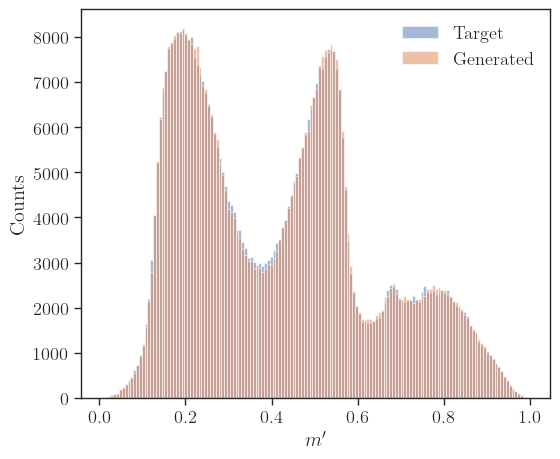

In [33]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,0], 150, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

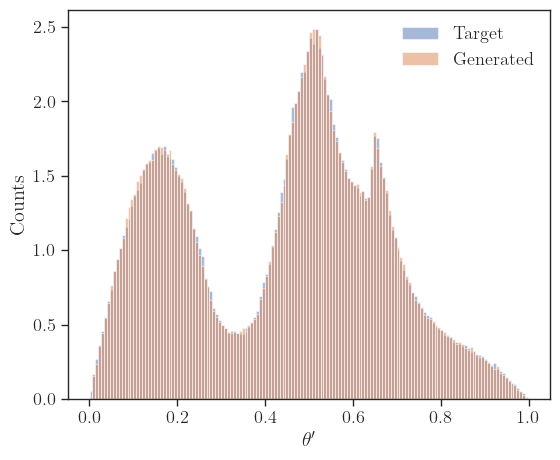

In [34]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,1], 150, alpha = 0.5, label = r'$\mathrm{Target}$', density = True)
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )

#ax.text(0.6, 0.8, rf'$\texttt{{K}} = {K}$ \\ $\texttt{{N\_{{samples}}}} = {N}$ \\ $\texttt{{epochs}} = {epochs}$ \\ $\texttt{{N\_{{blocks}}}} = {n_blocks}$', transform=ax.transAxes, fontsize = 10)

ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

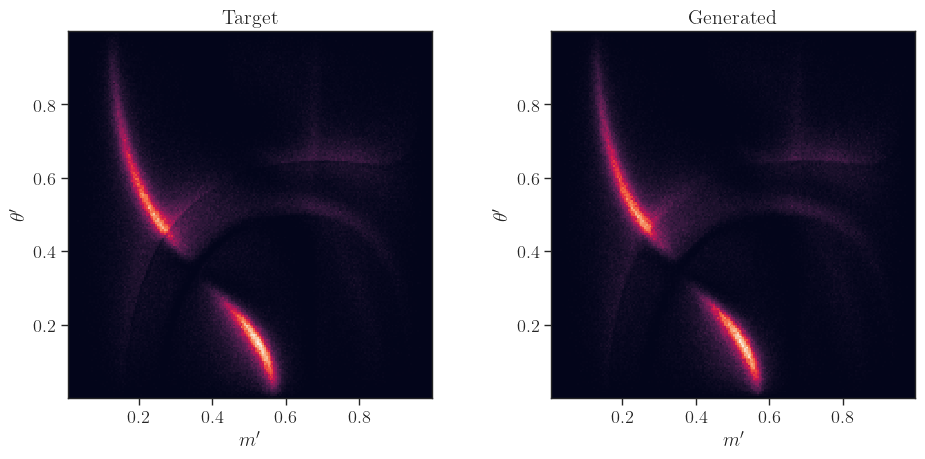

In [59]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:N,0], mp_thetap[:N,1], 200, rasterized=True)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges], rasterized=True)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

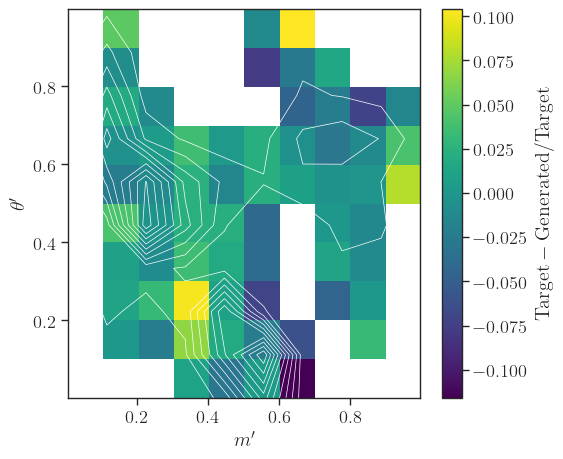

In [57]:
# Plot the per bin chi2 difference ignore bins with 0 entries
fig, ax = plt.subplots( figsize=(6,5) )
h_diff = (h_sim - h_gen) / h_sim
# Get rid of bins with counts less than 1000
h_diff[h_sim < 1000] = None
# Get rid of outliers
#h_diff[h_diff > 0.2] = 0.2
#h_diff[h_diff < -0.2] = -0.2
#h_diff = np.nan_to_num(h_diff)
im = ax.imshow(h_diff.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
#ax.set_xlim(0, 0.4)
#ax.set_ylim(0.4, 0.5)
fig.colorbar(im, ax=ax, label = r'$\mathrm{Target - Generated / Target}$')
# Overlay a contour of the target distribution
ax.contour(h_sim.T, levels=10, colors='white', linewidths=0.5, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
fig.tight_layout()
fig.savefig(r'figs/D_amplitude_SDP_INN_per_bin_diff.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [58]:
h_sim

array([[  110.,   325.,   432.,   575.,   646.,   672.,   725.,   829.,
          709.,   281.],
       [  944.,  2782.,  4553.,  5416.,  6226., 16946., 25944., 17645.,
         9162.,  2942.],
       [  436.,  1390.,  3118.,  5133., 38696., 36267.,  7178.,  1905.,
          845.,   311.],
       [ 1118.,  3371.,  5145.,  3521., 17818., 14665.,  3380.,   567.,
          210.,    78.],
       [ 5098., 23466., 27514.,  2380.,  4264.,  6991.,  1651.,   133.,
          435.,   518.],
       [26108., 43501.,  4318.,  1732.,  1159.,  4203.,  3084.,   766.,
         1411.,  1002.],
       [ 1362.,  1352.,   696.,   465.,   990.,  7347.,  8927.,  4589.,
         2838.,  1268.],
       [  308.,   900.,  1817.,  3017.,  5452.,  6081., 10776.,  3793.,
         1298.,   556.],
       [  455.,  1477.,  2065.,  2789.,  4528.,  3981.,  7783.,  2675.,
          783.,   285.],
       [  103.,   323.,   639.,   733.,   676.,  1096.,  1421.,  1051.,
          457.,    98.]])

In [108]:
# Save the model
torch.save(flow.state_dict(), 'models/INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model2.pth')

In [ ]:
# Load the model

"""
--- MODEL 1 ---
# Hyperparameters
n_train = 2_000_000
n_batch = 25_000
epochs = 40
learning_rate = 0.001
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 12
hidden_features = 100
# No LR scheduler
"""

n_blocks = 10
n_bins = 12
N = 200_000

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = 100, num_bins = n_bins)

flow.load_state_dict(torch.load('models/INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model1.pth'))
flow.eval()

"""
--- MODEL 2
# Hyperparameters
batch_size = 50000
epochs = 80
learning_rate = 0.005
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 25
hidden_features = 128
ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=2, min_lr=1e-6)
"""

n_blocks = 10
n_bins = 25
hidden_features = 128
N = 200_000

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

flow.load_state_dict(torch.load('models/INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model2.pth'))
flow.eval()

'\n--- MODEL 2\n'

In [15]:
@torch.no_grad()
def marginal_likelihood(flow, axis = 0, xs = None, nx = 400, ny = 800, 
                        on_unit_box = True, eps = 1e-8, data_range = None, 
                        batch = 65536, device = None):
    """
    Returns xs (np.ndarray of shape (nx,)) and log_likelihood_marginal (np.ndarray of shape (nx,))
    where log_likelihood_marginal[j] ~ log int p(x_axis = xs[j], other) d(other).

    flow: nflows.flows.Flow object
    axis: which axis to project out (0 or 1)
    xs: if provided, use these x values (np.ndarray of shape (nx,))
    nx: if xs is None, number of points along the projected axis
    ny: number of points along the marginalized axis
    on_unit_box: whether the flow was trained on [0,1]^2
    eps: if on_unit_box, avoid infinities by integrating over [eps, 1-eps]
    data_range: if not on_unit_box, the (min,max) for each axis; if None, uses [-3,3]
    batch: eval batch size for flow.log_prob
    device: torch device (default: "cuda" if available else "cpu")

    Returns:
    xs: np.ndarray of shape (nx,)
    log_marg: np.ndarray of shape (nx,)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # --- grids in DATA space ---
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    if xs is None:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
    else:
        xs = np.asarray(xs, dtype=np.float32)
        nx = xs.shape[0]

    ys = np.linspace(ymin, ymax, ny, dtype=np.float32)

    # Build full grid for evaluation: (ny * nx, 2)
    if axis == 0:
        XX = np.tile(xs, (ny, 1))                  # shape (ny, nx)
        YY = np.tile(ys[:, None], (1, nx))         # shape (ny, nx)
    else:
        XX = np.tile(ys[:, None], (1, nx))         # integrate over x if axis==1
        YY = np.tile(xs, (ny, 1))

    grid = np.stack([XX.ravel(), YY.ravel()], axis=1).astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)

    # Evaluate log p(x) on the grid (batched to be memory-safe)
    outs = []
    for i in range(0, grid_t.shape[0], batch):
        outs.append(flow.log_prob(grid_t[i:i+batch]))
    logp = torch.cat(outs, dim=0).view(ny, nx)     # reshape so axis 0 is the marginalized dim

    # Numerical integral: log ∫ p(x,y) dy ≈ logsumexp_y [ log p(x,y) ] + log Δy
    dy = (ymax - ymin) / (ny - 1)
    log_marg = torch.logsumexp(logp, dim=0) + torch.log(torch.tensor(dy, device=device))

    # CPU numpy outputs
    return xs, np.exp(log_marg.detach().cpu().numpy())

In [25]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

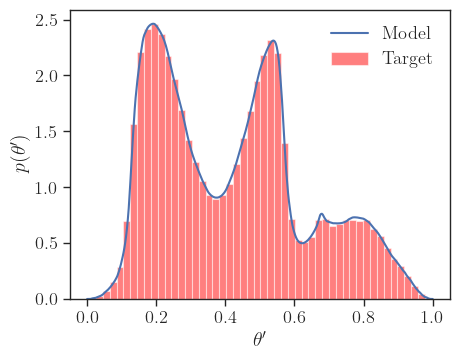

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:N,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')

ax.legend(loc = 'best', frameon = False)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

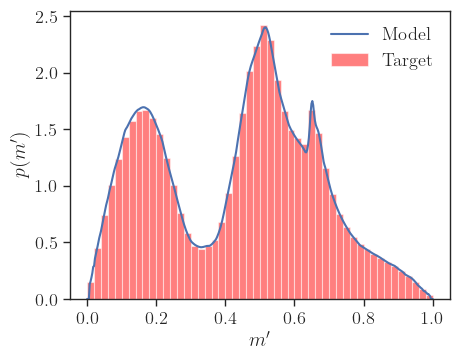

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')
#ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

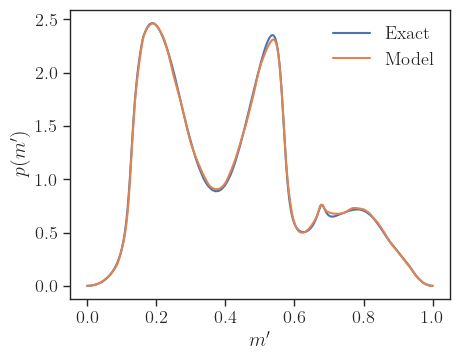

In [26]:
# Let's see if we can get the exact likelihood from the model that produced the training data
mprime_exact = np.load('data/D_Kpipi_mprime.npy')
dens_m = np.load('data/D_Kpipi_dGamma_dmprime.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(mprime_exact, dens_m, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

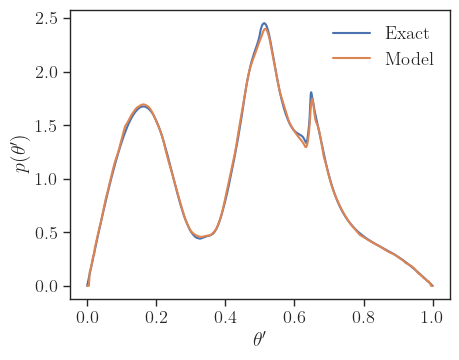

In [27]:
thetaprime_exact = np.load('data/D_Kpipi_thetaprime.npy')
dens_thetaprime = np.load('data/D_Kpipi_dGamma_dthetaprime.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(thetaprime_exact, dens_thetaprime, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [60]:
from DKpp import DKpp

In [61]:
@torch.no_grad()
def conditional_pdf(
    flow,
    fixed_value,
    fixed_axis=0,         # 0 → fix x1=m', 1 → fix x2=θ'
    nx=400,
    on_unit_box=True,
    eps=1e-8,
    data_range=None,
    device=None,
):
    """
    Compute conditional density p(x_free | x_fixed=fixed_value).

    Returns:
        xs   (np.ndarray): grid values of the free variable
        pdf  (np.ndarray): normalized conditional density over xs
        logp (np.ndarray): unnormalized log joint for inspection
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # ranges
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    # grid over the free variable
    if fixed_axis == 0:
        xs = np.linspace(ymin, ymax, nx, dtype=np.float32)
        pts = np.stack([np.full_like(xs, fixed_value, dtype=np.float32), xs], axis=1)
    else:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
        pts = np.stack([xs, np.full_like(xs, fixed_value, dtype=np.float32)], axis=1)

    pts_t = torch.from_numpy(pts).to(device)

    # joint log-prob for each slice point
    logp = flow.log_prob(pts_t).cpu().numpy()
    pdf = np.exp(logp - logp.max())       # stabilize
    pdf /= np.trapz(pdf, xs)              # normalize to 1

    return xs, pdf, logp

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


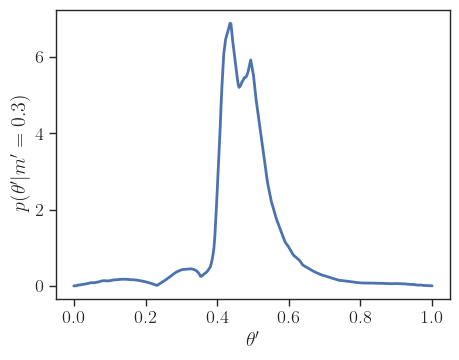

In [67]:
xs, pdf, logp = conditional_pdf(flow, fixed_value=0.3, fixed_axis=0,
                                nx=400, on_unit_box=True)

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(xs, pdf, lw = 2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta' | m'=0.3)$")
fig.tight_layout()

In [70]:
# Map m' -> m12 and s12
def mprime_to_m12(mprime, mmin, mmax):
    """CLEO/BaBar/Belle convention: m'(0)=mmax, m'(1)=mmin."""
    dM = mmax - mmin
    return mmin + 0.5*dM*(1.0 + np.cos(np.pi*mprime))

# Map theta' -> s13 along the kinematic arc at fixed s12
def thetap_to_s13(thetap, s13min, s13max):
    # Now θ'=0 -> s13min, θ'=1 -> s13max (increasing order)
    return 0.5*(s13max + s13min) - 0.5*(s13max - s13min)*np.cos(np.pi*thetap)

# Full Jacobian |\partial(s12,s13)/\partial(m',\theta')|
def jacobian(mprime, thetap, mmin, mmax, s13min, s13max):
    m12  = mprime_to_m12(mprime, mmin, mmax)
    dM   = (mmax - mmin)
    ds12_dmp  = -np.pi * dM * m12 * np.sin(np.pi*mprime)              # magnitude will be taken
    ds13_dthp = -0.5*np.pi * (s13max - s13min) * np.sin(np.pi*thetap) # magnitude will be taken
    return np.abs(ds12_dmp) * np.abs(ds13_dthp)

# Kallen function
def kallen(x,y,z):
    return x*x + y*y + z*z - 2*(x*y + x*z + y*z)

# Generic limits: given sij, return sik^{min,max}
# PDG three-body kinematics (M = parent mass, mi = masses of i,j,k)
def sik_limits_given_sij(sij, M, mi, mj, mk):
    M2 = M*M
    mi2, mj2, mk2 = mi*mi, mj*mj, mk*mk
    s = np.asarray(sij)
    # central term
    num = (s + mi2 - mj2)*(M2 - s - mk2)
    # phase-space term
    root = np.sqrt(np.maximum(kallen(s, mi2, mj2) * kallen(M2, s, mk2), 0.0))
    den = 2*s
    sik_max = mi2 + mk2 + (num + root)/den
    sik_min = mi2 + mk2 + (num - root)/den
    return sik_min, sik_max

In [71]:
def abs_ds13_dthetap(thetap, s13min, s13max):
    # |∂s13/∂θ'| for the square-Dalitz mapping
    return 0.5*np.pi*(s13max - s13min)*np.abs(np.sin(np.pi*thetap))

def abs_ds12_dmprime(mprime, mmin, mmax):
    # |∂s12/∂m'|
    m12 = mprime_to_m12(mprime, mmin, mmax)
    dM  = (mmax - mmin)
    return np.pi * dM * m12 * np.abs(np.sin(np.pi*mprime))

In [72]:
def conditional_theta_given_mprime(amp_obj, mprime, n_theta=400):
    """
    Returns (thetap_grid, pdf_theta), normalized so that ∫_0^1 pdf(θ'|m') dθ' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # fixed s12 from m'
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12

    # θ' grid (uniform is fine; we include the Jacobian below)
    thetap = np.linspace(0.0, 1.0, n_theta)

    # kinematic limits and map θ' -> s13(θ')
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)
    s13 = thetap_to_s13(thetap, s13min, s13max)

    # evaluate |A|^2 on the slice (m' fixed, θ' varying)
    pts = np.column_stack([np.full_like(s13, s12), s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s13/∂θ'|
    dens = mod2 * abs_ds13_dthetap(thetap, s13min, s13max)

    # normalize to unit area over θ'
    area = np.trapz(dens, thetap)
    pdf  = dens / (area + 1e-300)
    return thetap, pdf

# ================================================================
# p(m' | θ'): conditional PDF of m' at fixed θ'  (slice in m')
# ================================================================
def conditional_mprime_given_theta(amp_obj, thetap, n_mprime=400):
    """
    Returns (mprime_grid, pdf_mprime), normalized so that ∫_0^1 pdf(m'|θ') dm' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # m' grid (uniform; include |∂s12/∂m'| Jacobian below)
    mprime = np.linspace(0.0, 1.0, n_mprime)

    # for each m', build s12(m') and s13(θ' ; s12)
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)  # vectorized over m'
    s13 = thetap_to_s13(thetap, s13min, s13max)

    pts = np.column_stack([s12, s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s12/∂m'|
    dens = mod2 * abs_ds12_dmprime(mprime, mmin, mmax)

    # normalize to unit area over m'
    area = np.trapz(dens, mprime)
    pdf  = dens / (area + 1e-300)
    return mprime, pdf

In [75]:
dk = DKpp()

# Slice at fixed m' (e.g., m' = 0.35)
thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=0.3, n_theta=600)

# Slice at fixed θ' (e.g., θ' = 0.60)
mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=0.20, n_mprime=600)

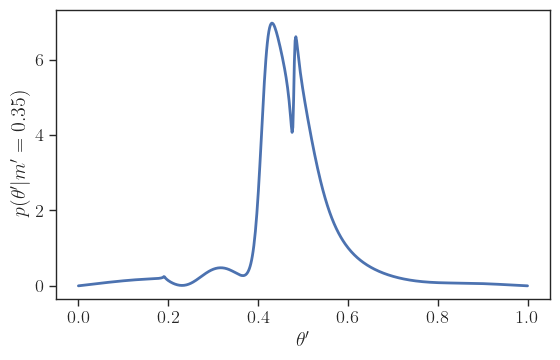

In [76]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(thp, p_th_given_m, lw=2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m'=0.35)$")
fig.tight_layout()

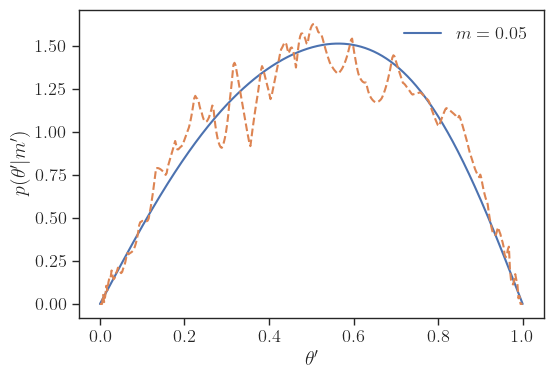

In [ ]:
# Define a set of m' slices
mprime_slices = [0.05]#np.linspace(0.05, 0.95, 10)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for mprime in mprime_slices:
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime, n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.5, label = rf'$m = {mprime:.2f}$')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=mprime, fixed_axis=0,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5)

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m')$")
ax.legend(loc='best', frameon=False)
#fig.tight_layout()

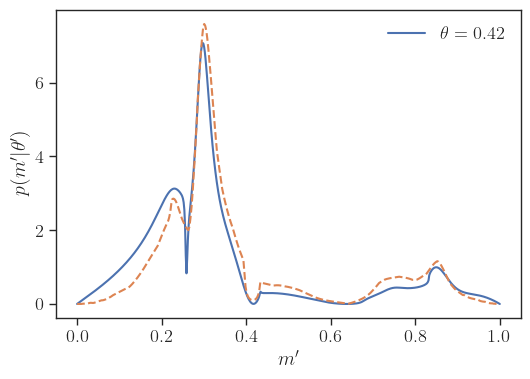

In [107]:
thetap_slices = [0.42]#np.linspace(0.05, 0.95, 10)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for thetap in thetap_slices:
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap, n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.5, label = rf'$\theta = {thetap:.2f}$')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap, fixed_axis=1,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5)

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$p(m'|\theta')$")
ax.legend(loc='best', frameon=False)